# Predictive Maintenance

In this notebook, we will explore various methods to handle the imbalance between the number of failures compared to non-failures.  In addition, we will attempt to fit various classification methods to the data in hopes of successsfully predicting a failure before it happens.

## Customize Enviornment

In [59]:
# load packages
packages <- c("purrr", "doMC", "RMySQL", "lubridate", "ggplot2", "caret", "DMwR", "pROC")
purrr::walk(packages, library, character.only = TRUE, warn.conflicts = FALSE)

# set default plot size
options(repr.plot.width=10, repr.plot.height=6)

# configure multicore processing
registerDoMC(cores=8)

## Load Data

In [4]:
# create an open connection to the database
cn <- dbConnect(drv = RMySQL::MySQL(),
                host = "host",
                port = 3306,
                user = "user",
                password = "password",
                dbname = "db")

# query the database and store the results into a DataFrame
df <- dbGetQuery(cn, "SELECT * FROM dryer3_10_min_before_down")
dbDisconnect(cn)

[1] TRUE

In [25]:
# save df to local machine
#saveRDS(df, "dryer3_10_min_before_down.Rda")
df_all <- readRDS("dryer3_10_min_before_down.Rda")
nrow(df_all)

[1] 60763

In [28]:
# remove rows without complete data
df <- df_all[complete.cases(df_all),]
nrow(df)

[1] 60682

In [29]:
# look at the rows with missing data
head(df_all[complete.cases(df_all) == FALSE, ])

,Datetime_10min,DOWN,CircFan1_max,CircFan1_mean,CircFan1_min,CircFan1_std,CircFan2_max,CircFan2_mean,CircFan2_min,CircFan2_std,⋯,Valve4_min,Valve4_std,Valve5_max,Valve5_mean,Valve5_min,Valve5_std,Valve6_max,Valve6_mean,Valve6_min,Valve6_std
1,2015-01-01 00:00:00,0,100,100,100,NA,100,100,100,NA,⋯,100,NA,100,100,100,NA,100,100,100,NA
826,2015-01-06 21:20:00,0,100,100,100,NA,100,100,100,NA,⋯,0,NA,0,0,0,NA,0,0,0,NA
966,2015-01-08 01:30:00,0,100,100,100,NA,100,100,100,NA,⋯,12,NA,14,14,14,NA,22,22,22,NA
1032,2015-01-08 14:30:00,0,100,100,100,NA,100,100,100,NA,⋯,100,NA,100,100,100,NA,100,100,100,NA
1224,2015-01-09 22:30:00,0,100,100,100,NA,100,100,100,NA,⋯,100,NA,100,100,100,NA,100,100,100,NA
1886,2015-01-14 17:40:00,0,100,100,100,NA,100,100,100,NA,⋯,22,NA,52,52,52,NA,90,90,90,NA


## Feature Engineering

In [30]:
# rename variable, convert to factor, and set names
names(df)[names(df)=="DOWN"] <- "Class"
df$Class  <- as.factor(df$Class)
levels(df$Class) <- make.names(c("notDown", "down"))

In [31]:
# create new variables for dates and time
df$Datetime_10min <- ymd_hms(df$Datetime_10min)
df$YEAR <- as.factor(year(df$Datetime_10min))
df$MONTH <- as.factor(month(df$Datetime_10min))
df$WDAY <- as.factor(wday(df$Datetime_10min))
df$HOUR <- as.factor(hour(df$Datetime_10min))
df$MINUTE <- as.factor(minute(df$Datetime_10min))
df$Datetime_10min <- NULL

In [32]:
# look at the number of variables
cat("Number of variables before:")
ncol(df)

# drop variables are are constant
df <- df[sapply(df, function(x) length(unique(na.omit(x)))) > 1]
    
# look at the number of variables
cat("\nNumber of variables after:")
ncol(df)

Number of variables before:

[1] 215


Number of variables after:

[1] 184

## Partition Data

In [33]:
# split data into traning and test
set.seed(1234)
trainIndex <- createDataPartition(df$Class, 
                                  p = .6, 
                                  list = FALSE, 
                                  times = 1)

imbal_train <- df[ trainIndex,]
non_train   <- df[-trainIndex,]

trainIndex <- createDataPartition(non_train$Class, 
                                  p = .5, 
                                  list = FALSE, 
                                  times = 1)

imbal_test  <- non_train[ trainIndex,]
imbal_valid <- non_train[-trainIndex,]

In [34]:
# compare downtime ratio in training and test
cat("Downtime ratio in training data:")
prop.table(table(imbal_train$Class))

cat("\nDowntime ratio in test data:")
prop.table(table(imbal_test$Class))

cat("\nDowntime ratio in validation data:")
prop.table(table(imbal_valid$Class))

Downtime ratio in training data:


    notDown        down 
0.993243614 0.006756386 


Downtime ratio in test data:


  notDown      down 
0.9932438 0.0067562 


Downtime ratio in validation data:


    notDown        down 
0.993325093 0.006674907 

## Balance Data

#### SMOTE (Synthetic Minority Over-sampling Technique) works by creating synthetic samples from the under-represented class instead of creating copies

In [35]:
set.seed(1234)
smote_train <- SMOTE(Class ~ ., 
                     data = imbal_train, 
                     perc.over = 1000)                         

cat("Number of events by type in the original dataset:")
table(imbal_train$Class)

cat("\nNumber of events by type in the balanced dataset:")
table(smote_train$Class)

Number of events by type in the original dataset:


notDown    down 
  36164     246 


Number of events by type in the balanced dataset:


notDown    down 
   4920    2706 

## Predict Downtime

### Bagged Classification

In [36]:
fitControl <- trainControl(method = "repeatedcv",
                           number = 5,
                           classProbs = TRUE,
                           summaryFunction = twoClassSummary)

In [38]:
set.seed(1234)
treebag_fit <- train(Class ~ ., 
                     data = smote_train,
                     method = "treebag",
                     nbagg = 50,
                     metric = "ROC",
                     preProc = c("range"),
                     trControl = fitControl,
                     na.action = na.exclude)

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“No variation for for: ExhaustFanMan_std, HeatRecSet_std”

In [39]:
treebag_fit

Bagged CART 

7626 samples
 183 predictor
   2 classes: 'notDown', 'down' 

Pre-processing: re-scaling to [0, 1] (222) 
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 6100, 6101, 6101, 6101, 6101 
Resampling results:

  ROC        Sens       Spec     
  0.9665711  0.9896341  0.9035448

 

In [40]:
# use model to predict training data
treebag_train <- predict(treebag_fit, imbal_train, type = "prob")
treebag_train$pred <- factor(ifelse(treebag_train$down >= .50, "down", "notDown"))
treebag_train <- cbind(treebag_train, actual = imbal_train$Class)
confusionMatrix(data = treebag_train$pred, reference = treebag_train$actual, positive = 'down')

Warning message in confusionMatrix.default(data = treebag_train$pred, reference = treebag_train$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown  down
   notDown   35865     0
   down        299   246
                                          
               Accuracy : 0.9918          
                 95% CI : (0.9908, 0.9927)
    No Information Rate : 0.9932          
    P-Value [Acc > NIR] : 0.9995          
                                          
                  Kappa : 0.6184          
 Mcnemar's Test P-Value : <2e-16          
                                          
            Sensitivity : 1.000000        
            Specificity : 0.991732        
         Pos Pred Value : 0.451376        
         Neg Pred Value : 1.000000        
             Prevalence : 0.006756        
         Detection Rate : 0.006756        
   Detection Prevalence : 0.014968        
      Balanced Accuracy : 0.995866        
                                          
       'Positive' Class : down            
                                          

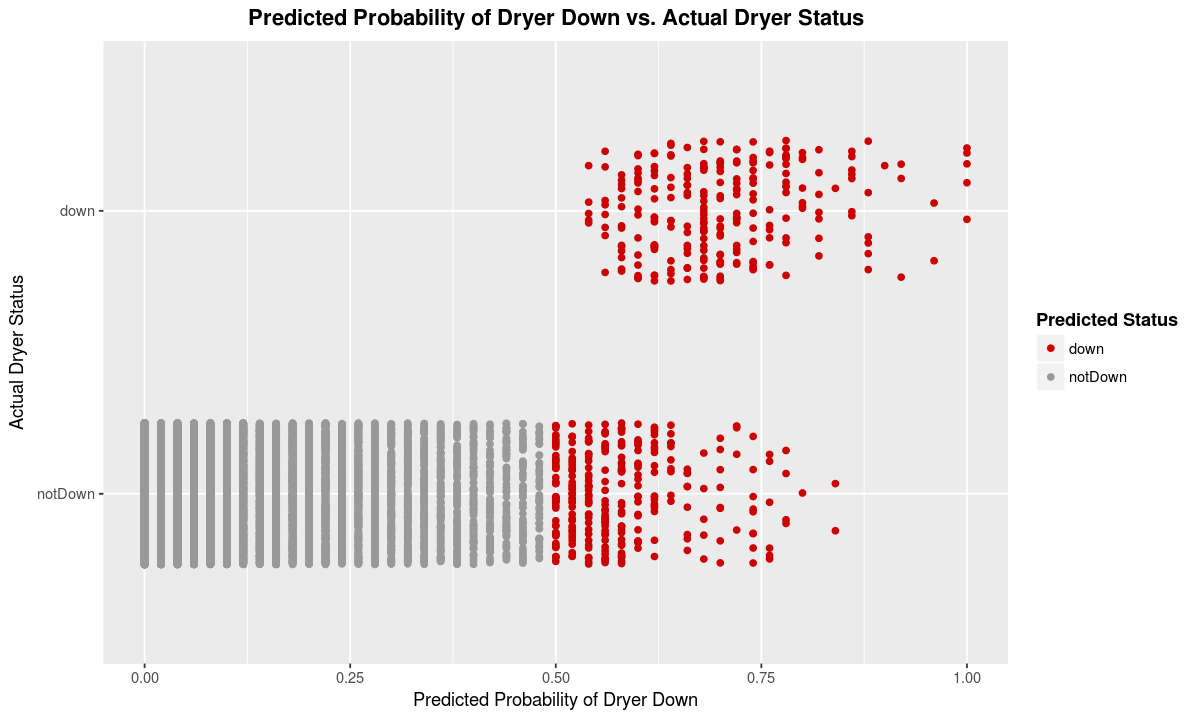

In [41]:
# plot the posterior probability vs actual
ggplot(data = treebag_train) +
  geom_point(mapping = aes(x = down, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

In [42]:
# use model to predict test data
treebag_test <- predict(treebag_fit, imbal_test, type = "prob")
treebag_test$pred <- factor(ifelse(treebag_test$down >= .50, "down", "notDown"))
treebag_test <- cbind(treebag_test, actual = imbal_test$Class)
confusionMatrix(data = treebag_test$pred, reference = treebag_test$actual, positive = 'down')

Warning message in confusionMatrix.default(data = treebag_test$pred, reference = treebag_test$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown  down
   notDown   11942    79
   down        113     3
                                          
               Accuracy : 0.9842          
                 95% CI : (0.9818, 0.9863)
    No Information Rate : 0.9932          
    P-Value [Acc > NIR] : 1.00000         
                                          
                  Kappa : 0.0226          
 Mcnemar's Test P-Value : 0.01724         
                                          
            Sensitivity : 0.0365854       
            Specificity : 0.9906263       
         Pos Pred Value : 0.0258621       
         Neg Pred Value : 0.9934282       
             Prevalence : 0.0067562       
         Detection Rate : 0.0002472       
   Detection Prevalence : 0.0095576       
      Balanced Accuracy : 0.5136058       
                                          
       'Positive' Class : down            
                                          

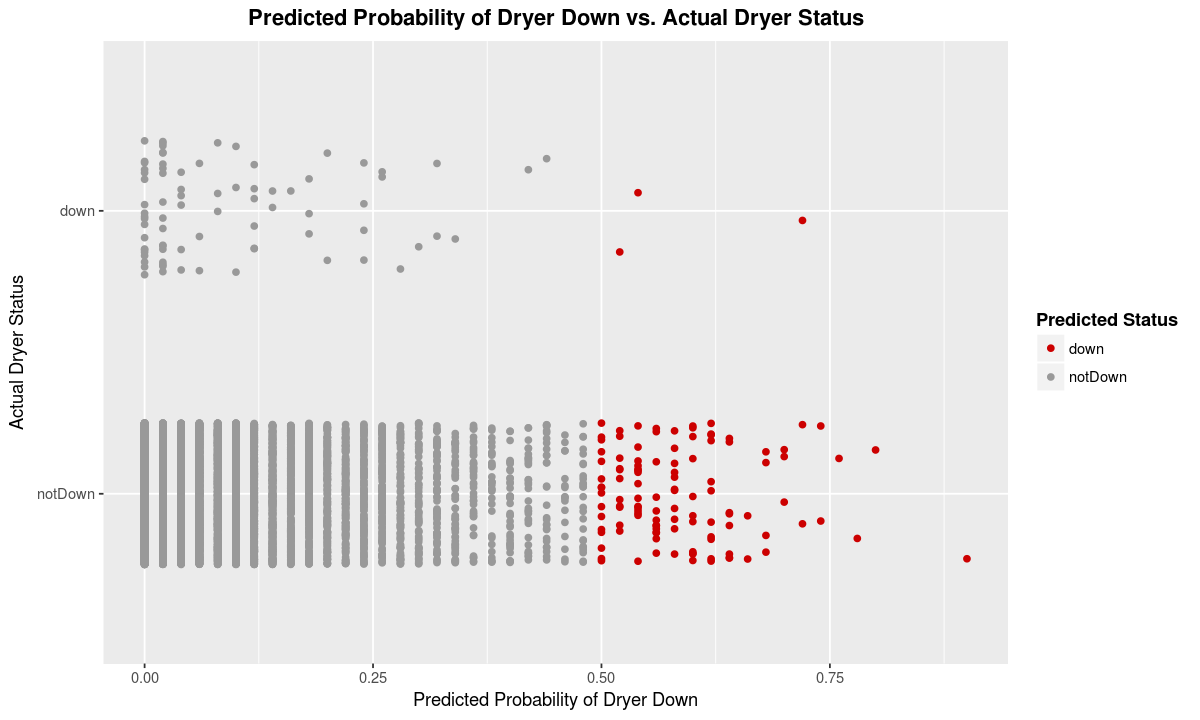

In [44]:
# plot the posterior probability vs actual
ggplot(data = treebag_test) +
  geom_point(mapping = aes(x = down, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

In [46]:
# use model to predict test data
treebag_valid <- predict(treebag_fit, imbal_valid, type = "prob")
treebag_valid$pred <- factor(ifelse(treebag_valid$down >= .50, "down", "notDown"))
treebag_valid <- cbind(treebag_valid, actual = imbal_valid$Class)
confusionMatrix(data = treebag_valid$pred, reference = treebag_valid$actual, positive = 'down')

Warning message in confusionMatrix.default(data = treebag_valid$pred, reference = treebag_valid$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown  down
   notDown   11931    77
   down        123     4
                                          
               Accuracy : 0.9835          
                 95% CI : (0.9811, 0.9857)
    No Information Rate : 0.9933          
    P-Value [Acc > NIR] : 1.000000        
                                          
                  Kappa : 0.0306          
 Mcnemar's Test P-Value : 0.001463        
                                          
            Sensitivity : 0.0493827       
            Specificity : 0.9897959       
         Pos Pred Value : 0.0314961       
         Neg Pred Value : 0.9935876       
             Prevalence : 0.0066749       
         Detection Rate : 0.0003296       
   Detection Prevalence : 0.0104656       
      Balanced Accuracy : 0.5195893       
                                          
       'Positive' Class : down            
                                          

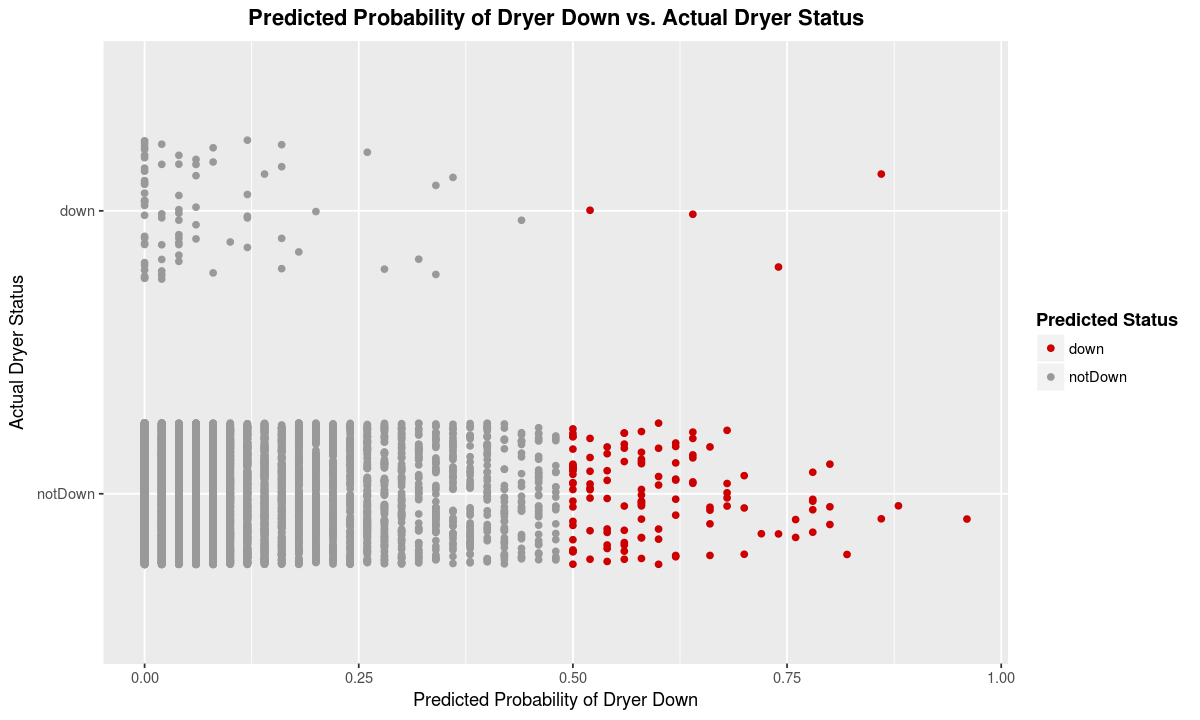

In [47]:
# plot the posterior probability vs actual
ggplot(data = treebag_valid) +
  geom_point(mapping = aes(x = down, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

Loading required package: rpart


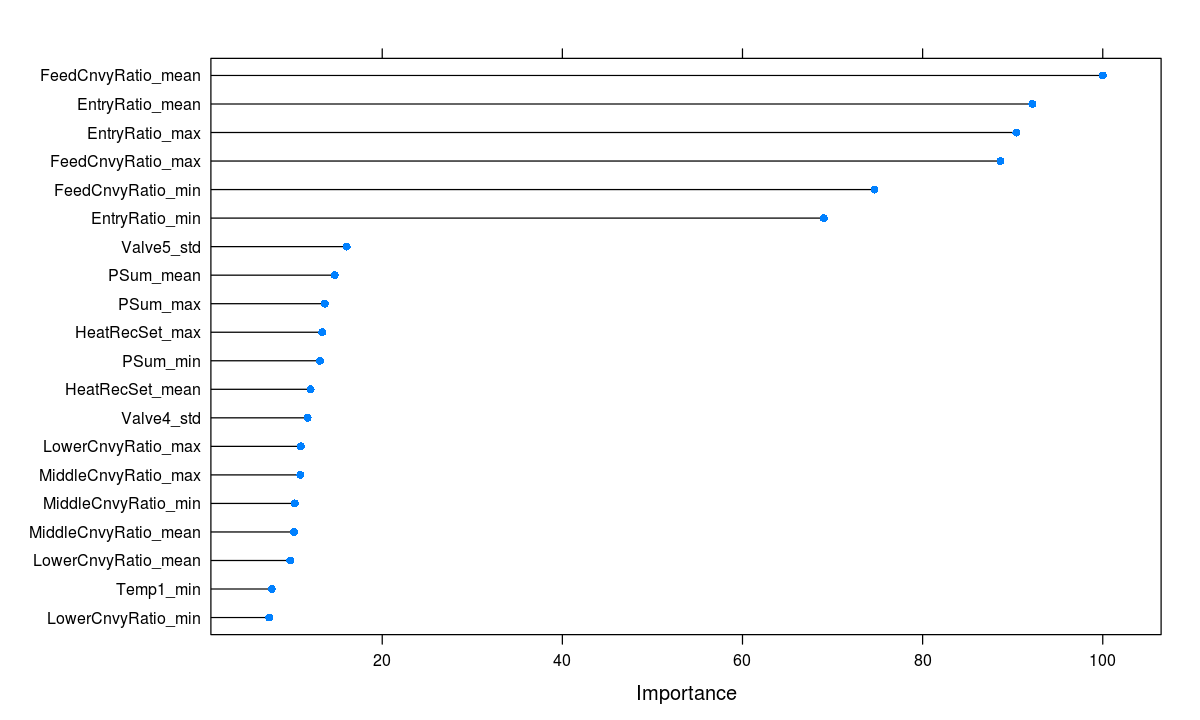

In [48]:
# plot variable importance
plot(varImp(treebag_fit), top=20)

### Other Approaches

In [50]:
set.seed(1234)
svm_fit <- train(Class ~ ., 
                 data = smote_train,
                 method = "svmRadialWeights",
                 metric = "ROC",
                 preProc = c("range"),
                 tuneGrid = expand.grid(C = c(1:5),
                                        sigma = c(0.05),
                                        Weight = c(1)),
                 trControl = fitControl,
                 na.action = na.exclude)

Warning message in preProcess.default(thresh = 0.95, k = 5, freqCut = 19, uniqueCut = 10, :
“No variation for for: ExhaustFanMan_std, HeatRecSet_std”Warning message in .local(x, ...):
“Variable(s) `' constant. Cannot scale data.”

In [51]:
svm_fit

Support Vector Machines with Class Weights 

7626 samples
 183 predictor
   2 classes: 'notDown', 'down' 

Pre-processing: re-scaling to [0, 1] (222) 
Resampling: Cross-Validated (5 fold, repeated 1 times) 
Summary of sample sizes: 6100, 6101, 6101, 6101, 6101 
Resampling results across tuning parameters:

  C  ROC        Sens       Spec     
  1  0.9412705  0.9491870  0.7793801
  2  0.9497287  0.9528455  0.8085778
  3  0.9549592  0.9540650  0.8215100
  4  0.9582614  0.9538618  0.8303790
  5  0.9607201  0.9544715  0.8348125

Tuning parameter 'sigma' was held constant at a value of 0.05
Tuning
 parameter 'Weight' was held constant at a value of 1
ROC was used to select the optimal model using  the largest value.
The final values used for the model were sigma = 0.05, C = 5 and Weight = 1. 

In [52]:
# use model to predict training data
svm_train <- predict(svm_fit, imbal_train, type = "prob")
svm_train$pred <- factor(ifelse(svm_train$down >= .85, "down", "notDown"))
svm_train <- cbind(svm_train, actual = imbal_train$Class)
confusionMatrix(data = svm_train$pred, reference = svm_train$actual, positive = 'down')

Warning message in confusionMatrix.default(data = svm_train$pred, reference = svm_train$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown  down
   notDown   35757   224
   down        407    22
                                         
               Accuracy : 0.9827         
                 95% CI : (0.9813, 0.984)
    No Information Rate : 0.9932         
    P-Value [Acc > NIR] : 1              
                                         
                  Kappa : 0.0571         
 Mcnemar's Test P-Value : 4.315e-13      
                                         
            Sensitivity : 0.0894309      
            Specificity : 0.9887457      
         Pos Pred Value : 0.0512821      
         Neg Pred Value : 0.9937745      
             Prevalence : 0.0067564      
         Detection Rate : 0.0006042      
   Detection Prevalence : 0.0117825      
      Balanced Accuracy : 0.5390883      
                                         
       'Positive' Class : down           
                                         

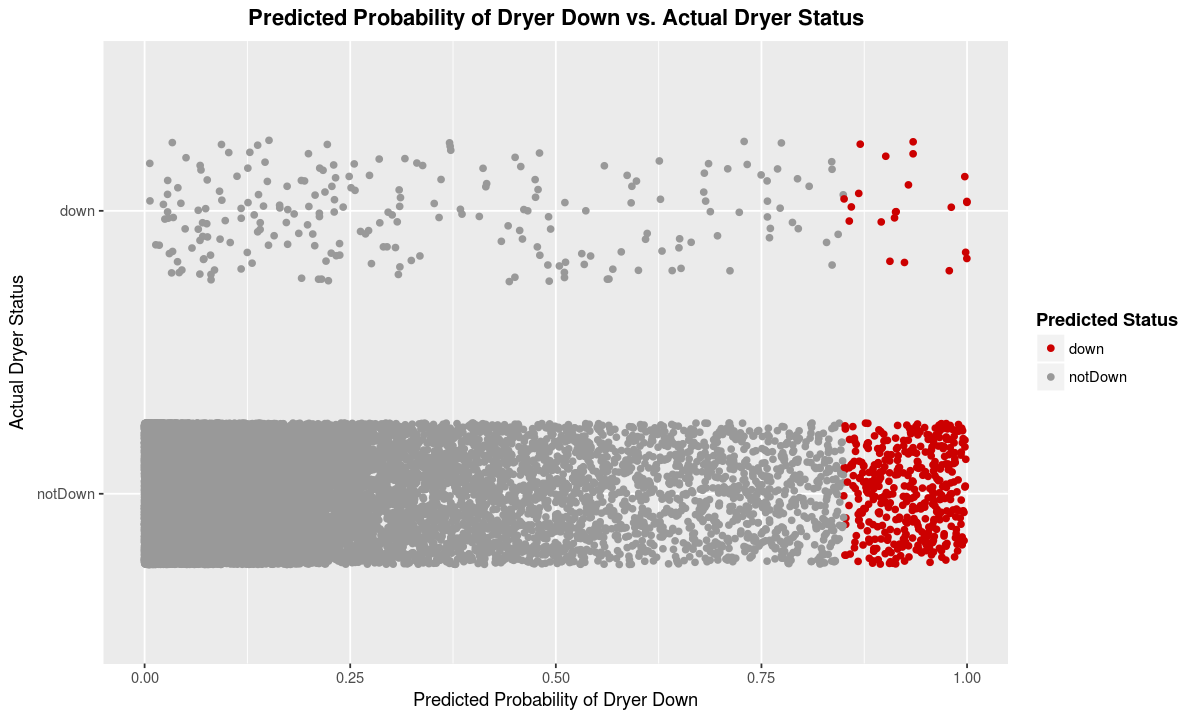

In [53]:
# plot the posterior probability vs actual
ggplot(data = svm_train) +
  geom_point(mapping = aes(x = down, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

In [54]:
# use model to predict test data
svm_test <- predict(svm_fit, imbal_test, type = "prob")
svm_test$pred <- factor(ifelse(svm_test$down >= 0.85, "down", "notDown"))
svm_test <- cbind(svm_test, actual = imbal_test$Class)
confusionMatrix(data = svm_test$pred, reference = svm_test$actual, positive = 'down')

Warning message in confusionMatrix.default(data = svm_test$pred, reference = svm_test$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown  down
   notDown   11912    78
   down        143     4
                                          
               Accuracy : 0.9818          
                 95% CI : (0.9793, 0.9841)
    No Information Rate : 0.9932          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0.0265          
 Mcnemar's Test P-Value : 1.669e-05       
                                          
            Sensitivity : 0.0487805       
            Specificity : 0.9881377       
         Pos Pred Value : 0.0272109       
         Neg Pred Value : 0.9934946       
             Prevalence : 0.0067562       
         Detection Rate : 0.0003296       
   Detection Prevalence : 0.0121117       
      Balanced Accuracy : 0.5184591       
                                          
       'Positive' Class : down            
                                          

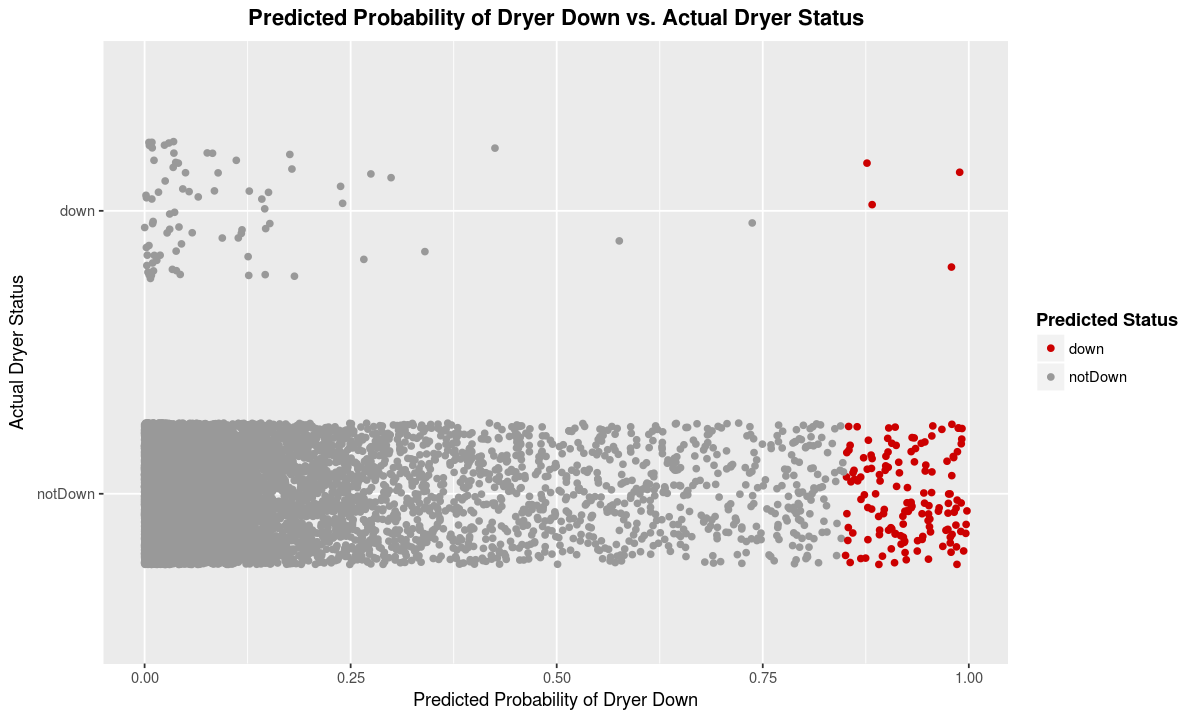

In [55]:
# plot the posterior probability vs actual
ggplot(data = svm_test) +
  geom_point(mapping = aes(x = down, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

In [56]:
# use model to predict validation data
svm_valid <- predict(svm_fit, imbal_valid, type = "prob")
svm_valid$pred <- factor(ifelse(svm_valid$down >= 0.85, "down", "notDown"))
svm_valid <- cbind(svm_valid, actual = imbal_valid$Class)
confusionMatrix(data = svm_valid$pred, reference = svm_valid$actual, positive = 'down')

Warning message in confusionMatrix.default(data = svm_valid$pred, reference = svm_valid$actual, :
“Levels are not in the same order for reference and data. Refactoring data to match.”

Confusion Matrix and Statistics

          Reference
Prediction notDown  down
   notDown   11905    80
   down        149     1
                                          
               Accuracy : 0.9811          
                 95% CI : (0.9785, 0.9835)
    No Information Rate : 0.9933          
    P-Value [Acc > NIR] : 1               
                                          
                  Kappa : 0               
 Mcnemar's Test P-Value : 7.004e-06       
                                          
            Sensitivity : 1.235e-02       
            Specificity : 9.876e-01       
         Pos Pred Value : 6.667e-03       
         Neg Pred Value : 9.933e-01       
             Prevalence : 6.675e-03       
         Detection Rate : 8.241e-05       
   Detection Prevalence : 1.236e-02       
      Balanced Accuracy : 5.000e-01       
                                          
       'Positive' Class : down            
                                          

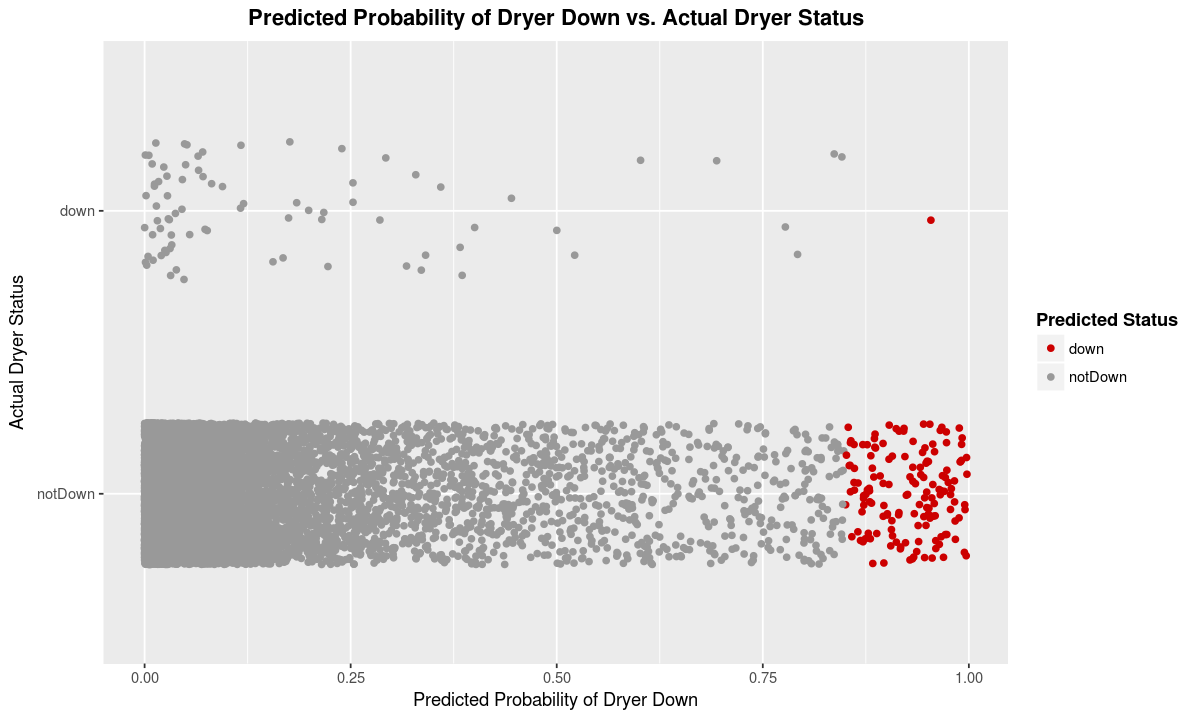

In [57]:
# plot the posterior probability vs actual
ggplot(data = svm_valid) +
  geom_point(mapping = aes(x = down, y = actual, color = pred), position = position_jitter(w = 0, h = 0.25)) +
  ggtitle("Predicted Probability of Dryer Down vs. Actual Dryer Status") + 
  theme(plot.title = element_text(lineheight=.8, face="bold", hjust = 0.5), ) +
  labs(x = "Predicted Probability of Dryer Down", y = "Actual Dryer Status") +
  theme(legend.title = element_text(face="bold"), legend.position = "right") +
  scale_color_manual(name = "Predicted Status", values = c("#CC0000", "#999999"))

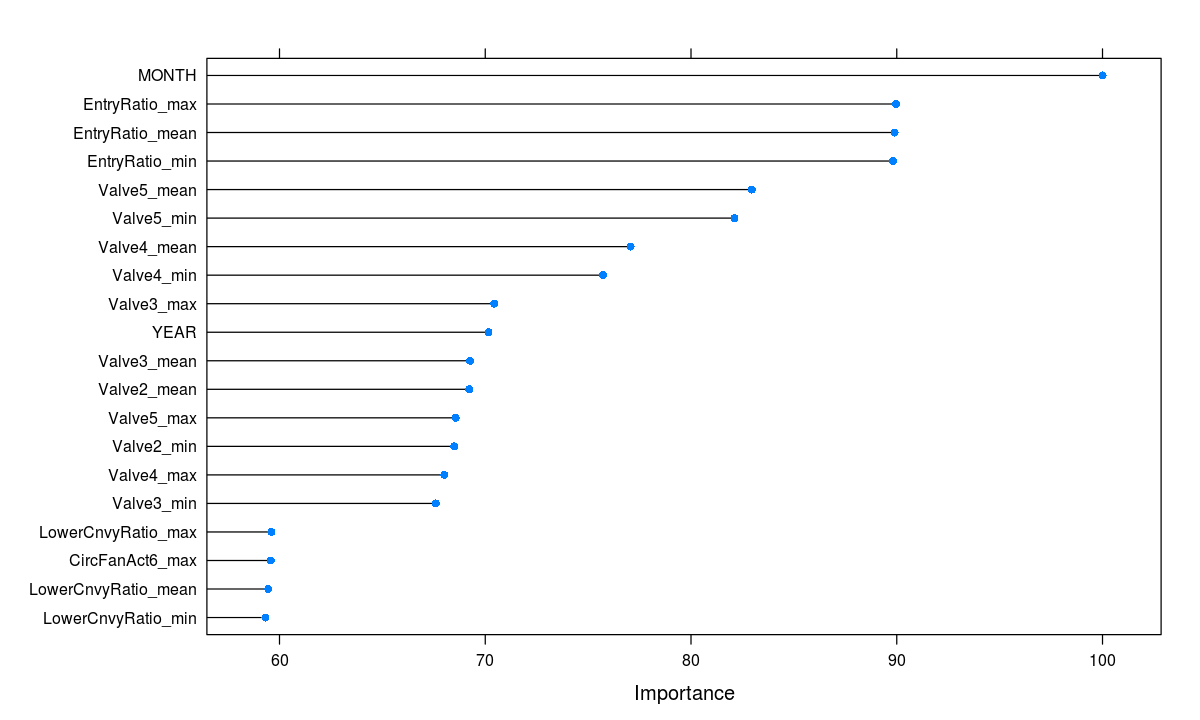

In [58]:
plot(varImp(svm_fit), top=20)